# 1. Data Preparation

## 1.1 Load data from text files and preprocess data

In [1]:
import re, string
def preprocess(textline):
    texts = textline.split("\n\n") #Split file into paragraphy
    for para in range(len(texts)):
        texts[para] = texts[para].lower() #turn into lower case
        texts[para] = re.sub(r'\n+', '', texts[para])# remove \n
        texts[para] = textline = re.sub(r'http\S+', '', texts[para]) # remove url
        texts[para] = re.sub("[^\w\d\s]+", '', texts[para])#only keep number and english letter
        texts[para] = texts[para].strip()
    while '' in texts:
        texts.remove('')   
    return texts

In [2]:
import pathlib
f_0 = open("data/28054-0.txt",encoding="UTF-8")
f_1 = open("data/pg1661.txt",encoding="UTF-8")
f_2 = open("data/pg31100.txt",encoding="UTF-8")
Fyodor_Dostoyevsky = f_0.read();
Arthur_Conan_Doyle = f_1.read();
Jane_Austen = f_2.read();
f_0.close()
f_1.close()
f_2.close()
Fyodor_Dostoyevsky = preprocess(Fyodor_Dostoyevsky)
Fyodor_Dostoyevsky = Fyodor_Dostoyevsky[19:5954]
Arthur_Conan_Doyle = preprocess(Arthur_Conan_Doyle)
Arthur_Conan_Doyle = Arthur_Conan_Doyle[14:2550]
Jane_Austen = preprocess(Jane_Austen)
Jane_Austen = Jane_Austen[28:11059]

In [3]:
import pandas as pd
def combind_text(texts_dataset,texts,label):
    dataset_part = pd.DataFrame()
    dataset_part['text'] = texts
    dataset_part['label'] = label
    dataset = pd.concat([texts_dataset,dataset_part], axis = 0, ignore_index=True)
    return dataset
    
data_set = pd.DataFrame()
data_set = combind_text(data_set,Fyodor_Dostoyevsky,0)
data_set = combind_text(data_set,Arthur_Conan_Doyle,1)
data_set = combind_text(data_set,Jane_Austen,2)

print(data_set) # You can view the final DataFrame 

                                                    text  label
0      alexey fyodorovitch karamazov was the third so...      0
1      he was married twice and had three sons the el...      0
2      immediately after the elopement adelaïda ivano...      0
3      one would think that youd got a promotion fyod...      0
4               chapter ii he gets rid of his eldest son      0
...                                                  ...    ...
19497  colonel brandon was now as happy as all those ...      2
19498  willoughby could not hear of her marriage with...      2
19499  for marianne however in spite of his incivilit...      2
19500  mrs dashwood was prudent enough to remain at t...      2
19501  between barton and delaford there was that con...      2

[19502 rows x 2 columns]


## 1.2 Data split

In [4]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y_ori, val_y_ori = train_test_split(data_set['text'].values, data_set['label'].values,
                                                                  test_size=0.2, random_state=1)


## 1.3 Feature Extraction: TF-IDF

### The reason I chose the stop words with 50 times frequency is using less memory space and make the process faster than without stopwords

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=50)
vectorizer.fit(data_set['text'])
train_vector = vectorizer.transform(train_x)
train_vector_array = train_vector.toarray()

test_vector = vectorizer.transform(val_x)
test_vector_array = test_vector.toarray()


In [6]:
import numpy as np
def OneHot(y, num_class=3):
    results = np.zeros((len(y), num_class))
    for index in range(len(y)):
        results[index][y[index]] = 1
    return results

train_y = OneHot(train_y_ori)
val_y = OneHot(val_y_ori)

---
# 2 Logistic Regression

In [7]:
def softmax(x):
    exps = np.exp(x)
    return exps/np.sum(exps,axis=1)[:,None]

## 2.1 Mini-Batch SGD

In [8]:
def mb_sgd_objective_gradient(w,x,y,lam):
    
    n,d = x.shape
    xw = np.dot(x,w)
    exp_xw = softmax(xw)
    obj = -np.mean(np.sum(y*np.log(exp_xw),axis=1)) + lam*np.sum(w*w)
    grad = (1/n) * np.dot(x.T,(exp_xw-y)) + 2 * lam * w
    
    return obj, grad

def mb_gradient_descent(x,y,lam,batch_size,stepsize,max_epochs,w=None):

    n,d = x.shape
    num_batch = int(np.ceil(n/batch_size))
    obj_vals = np.zeros(max_epochs)

    if w is None:
        w = np.zeros((d,3))

    for epoch in range(max_epochs):
        rand_index = np.random.permutation(n)
        x_rand = x[rand_index,:]
        y_rand =y[rand_index]
        obj_val = 0
        
        for i in range(1,num_batch+1):
            mini_x = x_rand[(i-1)*batch_size:i*batch_size, :]
            mini_y = y_rand[(i-1)*batch_size:i*batch_size]
      
            obj, g = mb_sgd_objective_gradient(w,mini_x,mini_y,lam)
            
            obj_val += obj
            w -= stepsize * g
    
        obj_val = obj_val * batch_size / num_batch
        obj_vals[epoch] = obj_val
        print('Objective value at ' + str(epoch) + ' is ' + str(obj_val))
    
    return w, obj_vals
w_mbgd, obj_vals_mbgd = mb_gradient_descent(train_vector_array, train_y, 1E-6, 8, stepsize = 0.1, max_epochs = 100, w=None)

Objective value at 0 is 6.669225716686155
Objective value at 1 is 5.3917973161234105
Objective value at 2 is 4.798054347704802
Objective value at 3 is 4.415134023497041
Objective value at 4 is 4.140683586903229
Objective value at 5 is 3.9339709668720872
Objective value at 6 is 3.7689886453093178
Objective value at 7 is 3.6333756856161283
Objective value at 8 is 3.51870825043311
Objective value at 9 is 3.421620539140677
Objective value at 10 is 3.336048527688785
Objective value at 11 is 3.267317405545559
Objective value at 12 is 3.202547698227153
Objective value at 13 is 3.1337853896512073
Objective value at 14 is 3.0788384577221457
Objective value at 15 is 3.029443511722128
Objective value at 16 is 2.9843090745154432
Objective value at 17 is 2.9419396659570882
Objective value at 18 is 2.902421261117986
Objective value at 19 is 2.86887231849782
Objective value at 20 is 2.8327326441026317
Objective value at 21 is 2.801162546221158
Objective value at 22 is 2.7755795714410114
Objective val

## 2.2 SGD

In [9]:
def sgd_objective_gradient(w,x,y,lam):
    
    #y_mat = OneHot(y)
    xw = np.dot(x,w)
    exp_xw = softmax(xw)
    
    obj = -np.mean(np.sum(y * np.log(exp_xw),axis=1)) + lam*np.sum(w*w)
    
    grad = -np.dot(x.T,(y - exp_xw)) + 2 * lam * w
    
    return obj, grad
def sgd(x,y,lam,stepsize,max_epochs,w=None):
    n,d = x.shape
    obj_vals = np.zeros(max_epochs)
    
    if w is None:
        w = np.zeros((d,3))

    for epoch in range(max_epochs):
        rand_index = np.random.permutation(n)
        x_rand = x[rand_index,:]
        y_rand = y[rand_index]
        obj_val = 0
        
        for i in range(n):
            xi = x_rand[i, :].reshape(1, -1)
            yi = y_rand[i]
      
            obj, g = sgd_objective_gradient(w,xi,yi,lam)
            obj_val += obj
            w -= stepsize * g
        stepsize *= 0.9
        obj_val /= n
        obj_vals[epoch] = obj_val
        print('Objective value at ' + str(epoch) + ' is ' + str(obj_val))
    
    return w, obj_vals
w_sgd, obj_vals_sgd = sgd(train_vector_array, train_y, 1E-6, stepsize = 0.1 ,max_epochs = 100, w=None)

Objective value at 0 is 0.5853714259665552
Objective value at 1 is 0.41517329860110985
Objective value at 2 is 0.36875468243765813
Objective value at 3 is 0.3436082089184298
Objective value at 4 is 0.32744748713201555
Objective value at 5 is 0.3158322906054226
Objective value at 6 is 0.3071817275812186
Objective value at 7 is 0.300540029905089
Objective value at 8 is 0.29510189027456646
Objective value at 9 is 0.2906826925607721
Objective value at 10 is 0.28711595815184565
Objective value at 11 is 0.2840235571060815
Objective value at 12 is 0.2814159661489312
Objective value at 13 is 0.2792224057182327
Objective value at 14 is 0.27725088927970326
Objective value at 15 is 0.27564838135120323
Objective value at 16 is 0.27418645530032043
Objective value at 17 is 0.27289112981471214
Objective value at 18 is 0.2718180054415487
Objective value at 19 is 0.27082948110770766
Objective value at 20 is 0.2699869183123977
Objective value at 21 is 0.2692243411728862
Objective value at 22 is 0.268554

## 2.3 Compare SGD and MB_GD

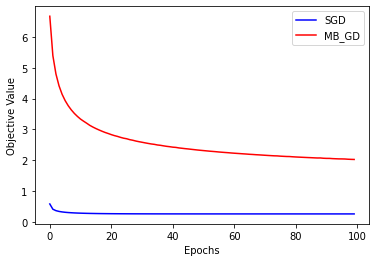

In [10]:
import matplotlib.pyplot as plt

line0, = plt.plot(range(len(obj_vals_sgd)), obj_vals_sgd, 'b')
line1, = plt.plot(range(len(obj_vals_mbgd)), obj_vals_mbgd, 'r')
plt.xlabel('Epochs')
plt.ylabel('Objective Value')
plt.legend([line0, line1], ['SGD', 'MB_GD'])
plt.show()

---
# 3 MLP 


In [11]:
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical

Using TensorFlow backend.


In [12]:
train_labels = to_categorical(train_y_ori)
test_labels = to_categorical(val_y_ori)

#Build the model

#3-Layer MLP:
#    1. The size of input layer is same with the dimension of single data sample
#    2. Output: 128, 3
#    3. Use softmax as the activation function at last layer
#    4. We choose adam as optimizer

model = Sequential()
model.add(layers.Dense(128, activation = 'relu', input_shape = (train_vector_array.shape[1],)))
model.add(layers.Dense(3, activation = 'softmax'))

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_vector_array, train_labels, epochs=100, batch_size=64, validation_split=0.2)

Train on 12480 samples, validate on 3121 samples
Epoch 1/100
12480/12480 [==============================] - 1s 91us/step - loss: 0.6193 - accuracy: 0.7536 - val_loss: 0.3791 - val_accuracy: 0.8686
Epoch 2/100
12480/12480 [==============================] - 1s 76us/step - loss: 0.2994 - accuracy: 0.8899 - val_loss: 0.3033 - val_accuracy: 0.8757
Epoch 3/100
12480/12480 [==============================] - 1s 74us/step - loss: 0.2341 - accuracy: 0.9131 - val_loss: 0.2939 - val_accuracy: 0.8847
Epoch 4/100
12480/12480 [==============================] - 1s 74us/step - loss: 0.2051 - accuracy: 0.9238 - val_loss: 0.3017 - val_accuracy: 0.8811
Epoch 5/100
12480/12480 [==============================] - 1s 72us/step - loss: 0.1864 - accuracy: 0.9316 - val_loss: 0.3175 - val_accuracy: 0.8795
Epoch 6/100
12480/12480 [==============================] - 1s 72us/step - loss: 0.1720 - accuracy: 0.9353 - val_loss: 0.3307 - val_accuracy: 0.8750
Epoch 7/100
12480/12480 [==============================] - 1s 7

Epoch 56/100
12480/12480 [==============================] - 1s 72us/step - loss: 0.0187 - accuracy: 0.9934 - val_loss: 1.1350 - val_accuracy: 0.8475
Epoch 57/100
12480/12480 [==============================] - 1s 71us/step - loss: 0.0184 - accuracy: 0.9934 - val_loss: 1.1610 - val_accuracy: 0.8456
Epoch 58/100
12480/12480 [==============================] - 1s 71us/step - loss: 0.0184 - accuracy: 0.9938 - val_loss: 1.1639 - val_accuracy: 0.8472
Epoch 59/100
12480/12480 [==============================] - 1s 72us/step - loss: 0.0187 - accuracy: 0.9933 - val_loss: 1.1805 - val_accuracy: 0.8465
Epoch 60/100
12480/12480 [==============================] - 1s 71us/step - loss: 0.0182 - accuracy: 0.9935 - val_loss: 1.1886 - val_accuracy: 0.8465
Epoch 61/100
12480/12480 [==============================] - 1s 72us/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 1.1938 - val_accuracy: 0.8433
Epoch 62/100
12480/12480 [==============================] - 1s 75us/step - loss: 0.0175 - accuracy: 0.9938

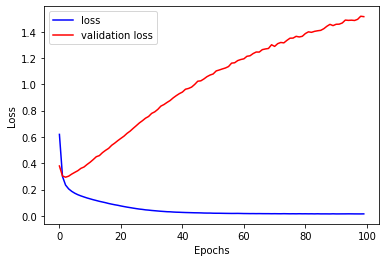

In [14]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
line0, = plt.plot(range(len(loss_values)), loss_values, 'b')
line1, = plt.plot(range(len(loss_values)), val_loss_values, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend([line0, line1], ['loss', 'validation loss'])
plt.show()

### I used Sequential from keras package which is MLP model. From the model, I can choose the ratio of validation for cross validation. I chose 20% for validation. From the graph we can see that the model is overfitting from first several epochs. This result means that trained model cannot generalize on novel dataset.
### Therefore, I suggest that epoch should be reduced in the next training or we can choose the trained model from epoch 5.

---
# 4 Compare LR modal with MLP model

## 4.1 Get perception and Recall of two model

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
preditions = model.predict_classes(test_vector_array)
preditions = OneHot(preditions)
perception = precision_score(val_y,preditions,average="macro")
recall = recall_score(val_y,preditions,average="macro")
print("MLP perception = "+str(perception))
print("MLP Recall = "+str(recall))

MLP perception = 0.7956596361407984
MLP Recall = 0.7933742653812382


In [16]:
def predict(x,w):
    wx = np.dot(x,w)
    temp = softmax(wx)
    return (temp == temp.max(axis=1)[:,None]).astype(int)


In [17]:
preditions = predict(test_vector_array,w_sgd)
perception = precision_score(val_y,preditions,average="macro")
recall = recall_score(val_y,preditions,average="macro")
print("LR with SGD perception = "+str(perception))
print("LR with SGD Recall = "+str(recall))

LR with SGD perception = 0.831196076698328
LR with SGD Recall = 0.8122264035712682


In [18]:
preditions = predict(test_vector_array,w_mbgd)
perception = precision_score(val_y,preditions,average="macro")
recall = recall_score(val_y,preditions,average="macro")
print("LR with MBGD perception = "+str(perception))
print("LR with MBGD Recall = "+str(recall))

LR with MBGD perception = 0.8322800338512518
LR with MBGD Recall = 0.8161993636228977


## 4.2 Analyze

### From perceptioin and recall of LR and MLP, there is no big difference between the two model. LR has only one weight for the model, but the overfitting of MLP is the problem of a model with multiple weights. 